In [1]:
import numpy as np
import pandas as pd
from scipy.io import arff
import umap
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

## Load data

In [2]:
data = arff.loadarff('Waveform_withoutdupl_v10.arff')
df = pd.DataFrame(data[0])
df.shape

(3443, 23)

In [3]:
df.head()

att1  att2  att3  att4  att5  att6  att7  att8  att9  att10  ...  att14  \
0 -0.89 -0.87 -0.01  1.04  1.02 -0.22  3.14  1.12  0.33   1.95  ...   3.17   
1  0.67  1.25  2.24  0.91  3.56  5.28  6.83  6.39  4.02   3.39  ...   0.76   
2 -0.98  0.14  2.91  0.76  2.79  5.80  4.88  3.43  3.77   4.04  ...  -0.25   
3 -0.96  0.13  0.13 -0.70  2.89  1.26  3.48  4.36  0.59   2.37  ...   2.60   
4 -0.26 -0.17  0.53  0.26  0.94  2.29  1.58  0.76  3.15   1.06  ...   4.81   

   att15  att16  att17  att18  att19  att20  att21      id  outlier  
0   4.96   3.99   4.18   3.54   1.62   0.90   1.02  4826.0   b'yes'  
1  -0.38  -0.40  -0.21  -0.25  -1.06  -1.28  -0.65  2495.0   b'yes'  
2   1.84   2.05  -0.49  -1.06   0.90   1.07  -0.88   563.0   b'yes'  
3   3.66   3.06   1.41   1.09   1.25  -0.29  -0.41    26.0   b'yes'  
4   3.74   0.67   2.69   0.90   0.49   0.72  -0.88  2119.0   b'yes'  

[5 rows x 23 columns]

In [4]:
# target
target = (df['outlier'] == b'yes').astype(int)

# raw data
data = df[[i for i in df.columns if 'att' in i]]

# normalized
scaler = StandardScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

# umap
emb = umap.UMAP(n_neighbors=30)
data_umap = pd.DataFrame(emb.fit_transform(data.values), columns=['att1', 'att2'])

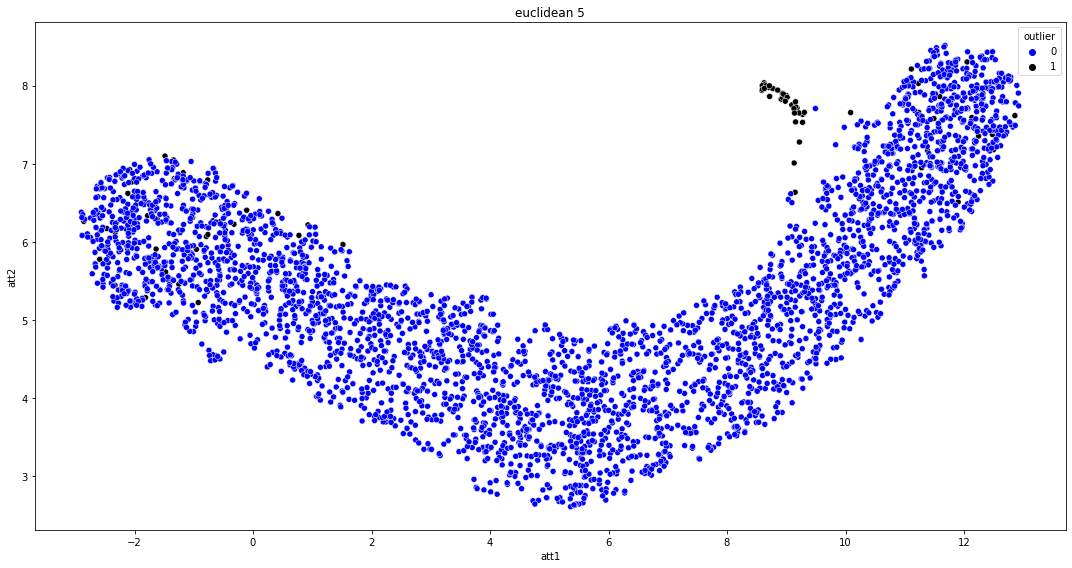

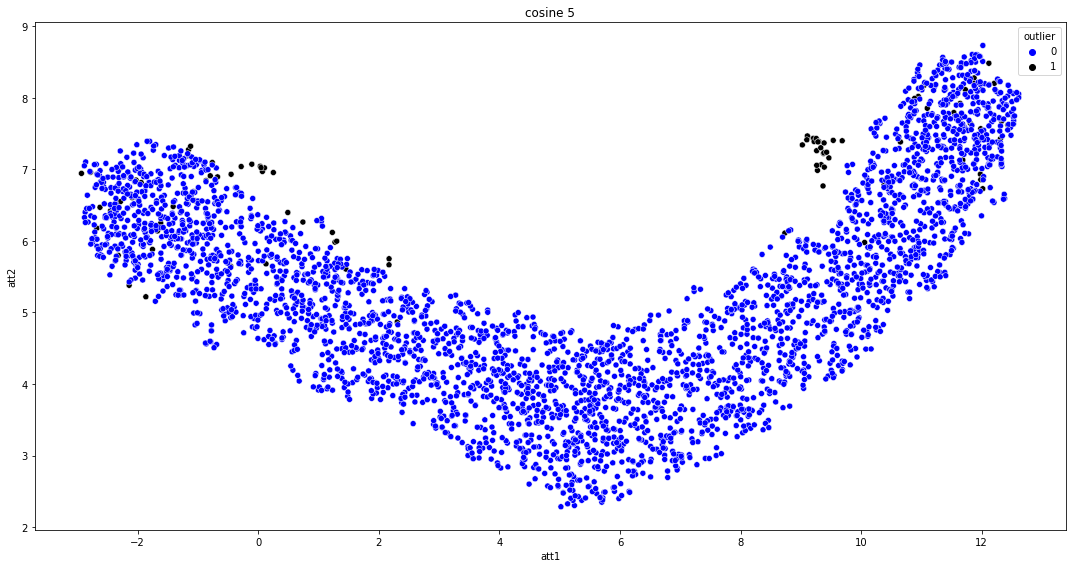

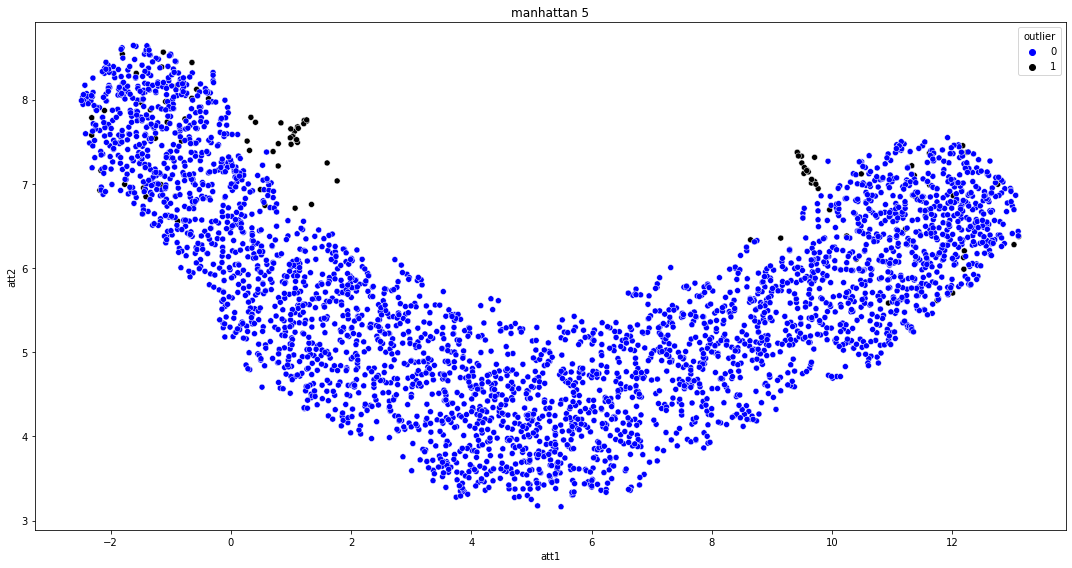

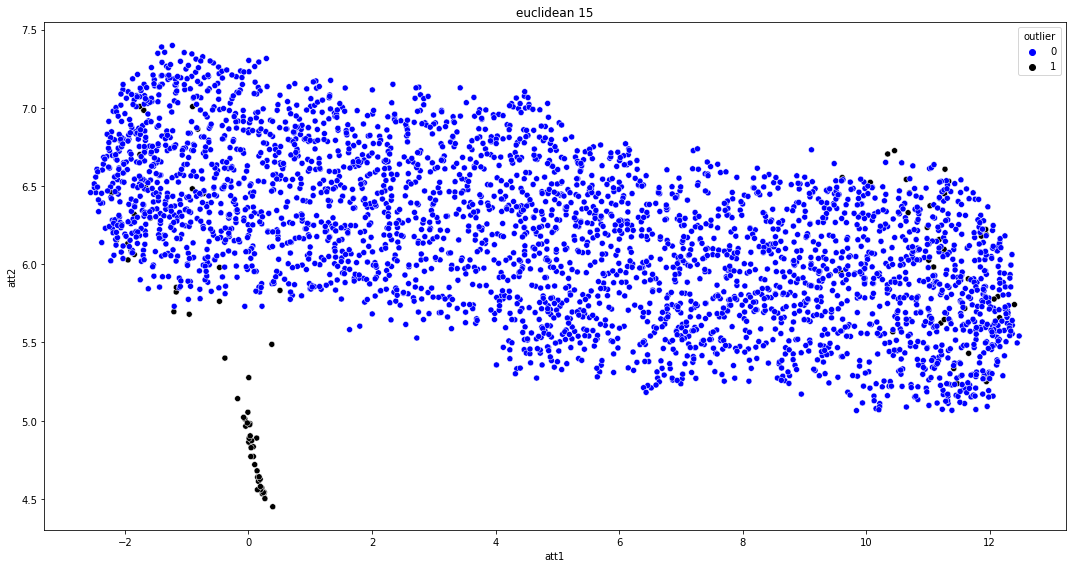

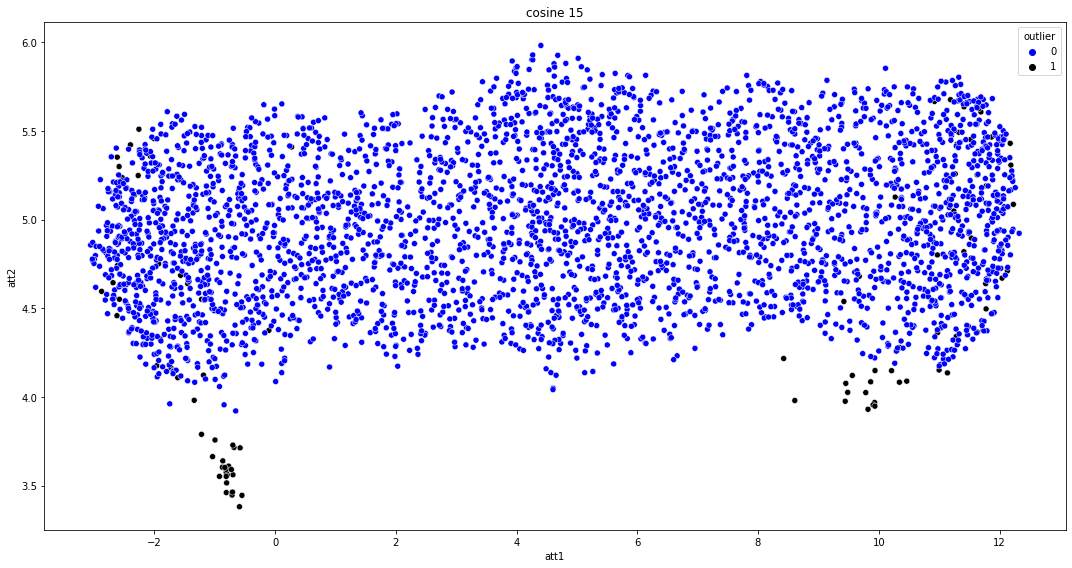

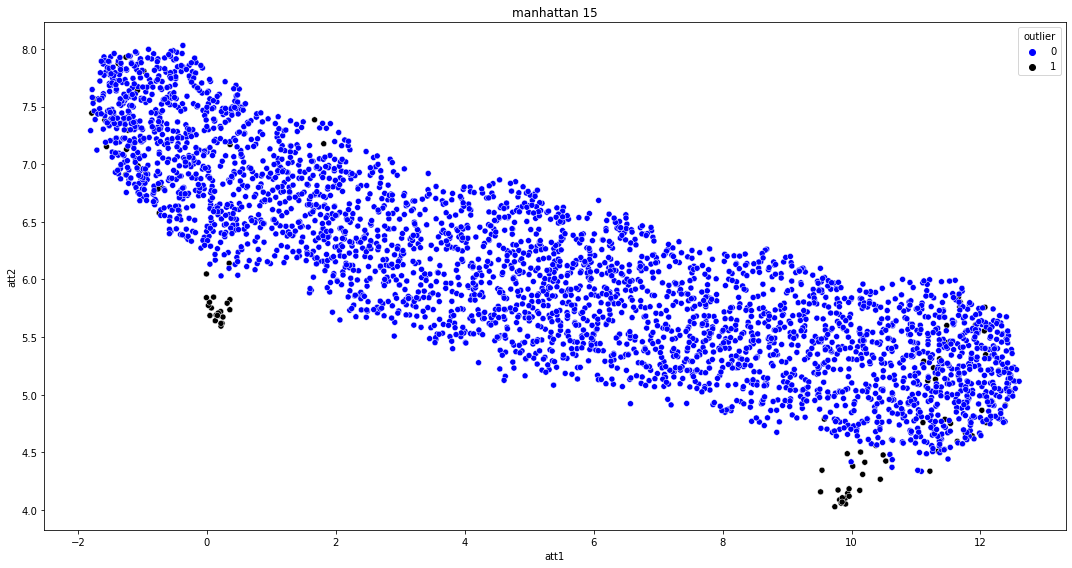

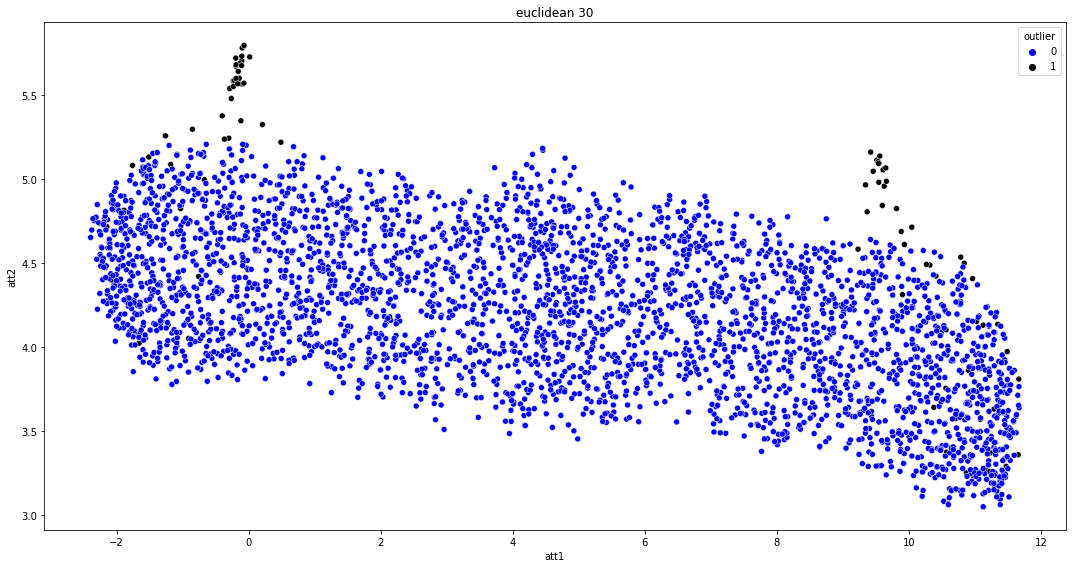

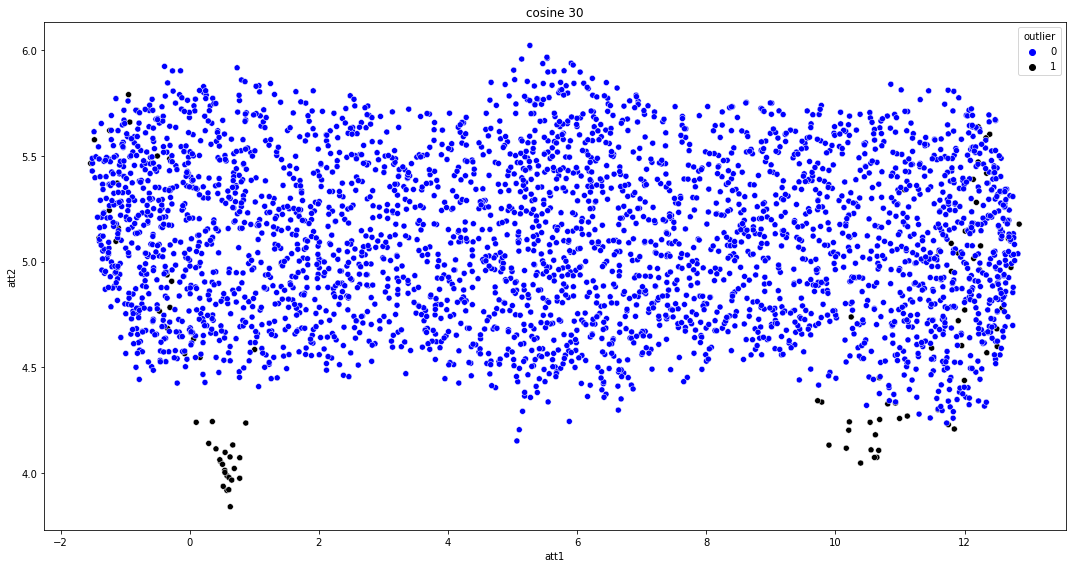

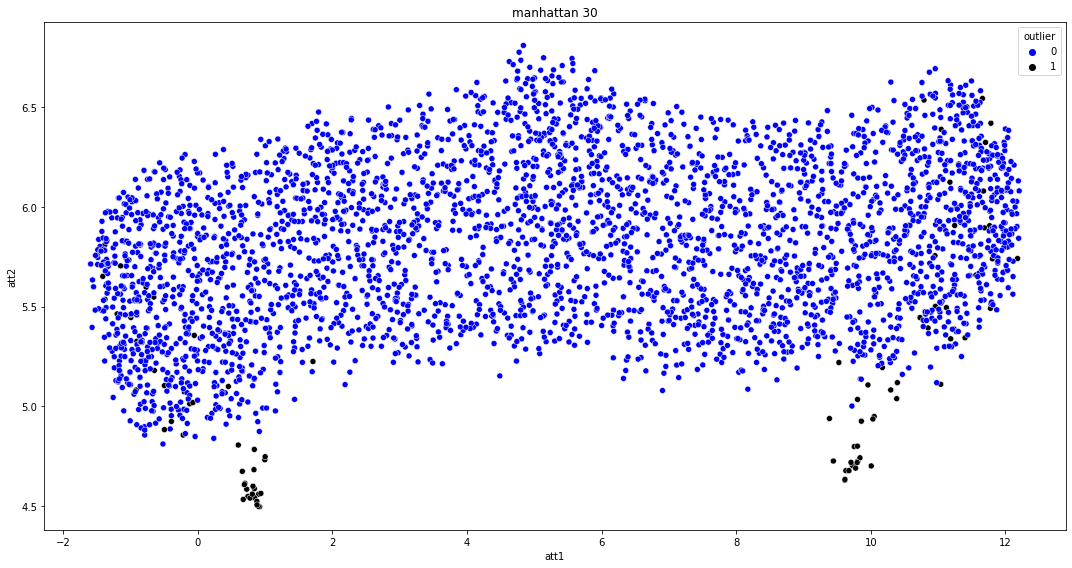

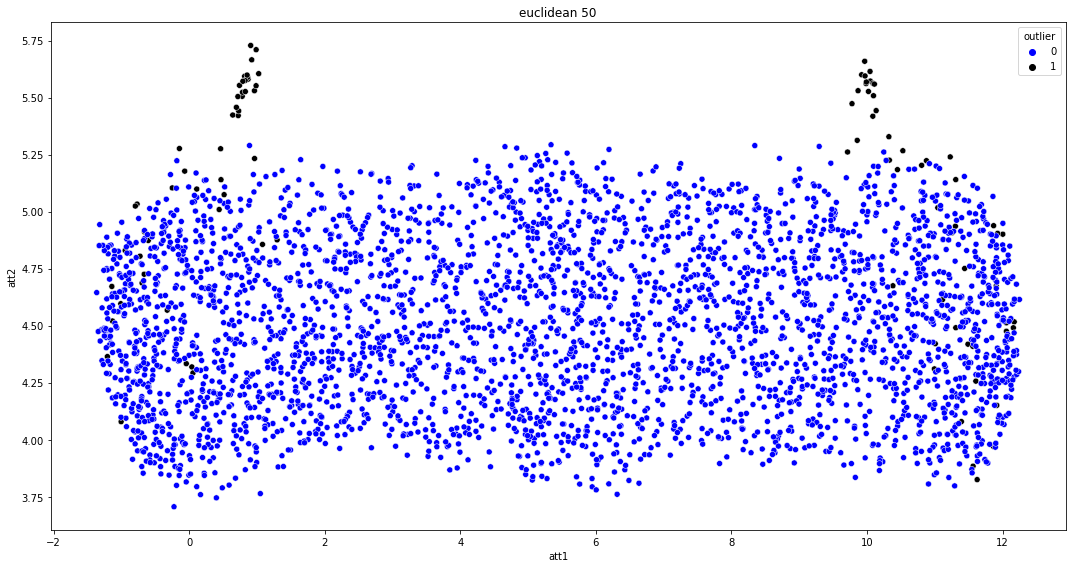

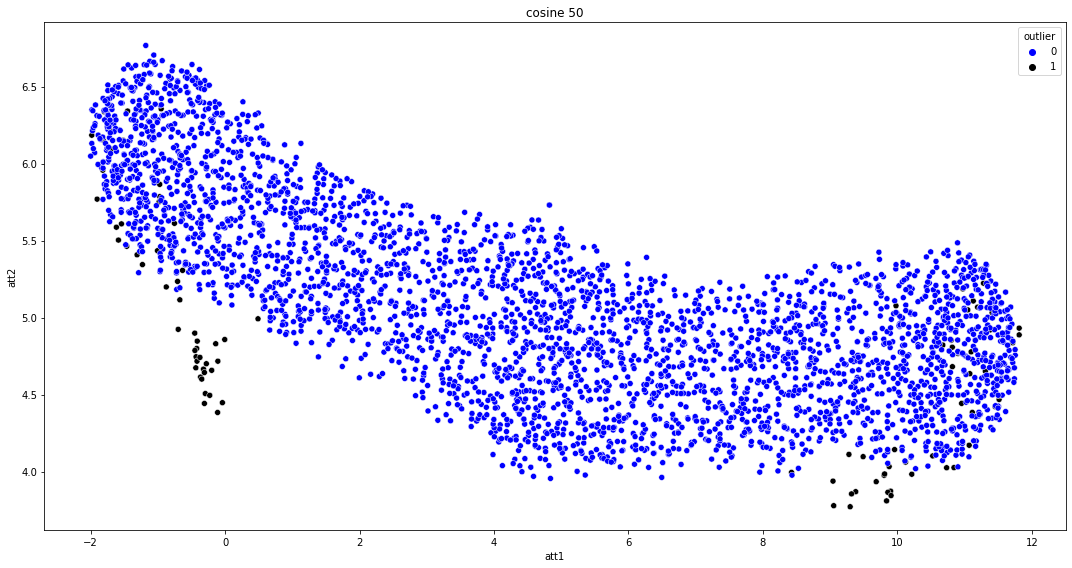

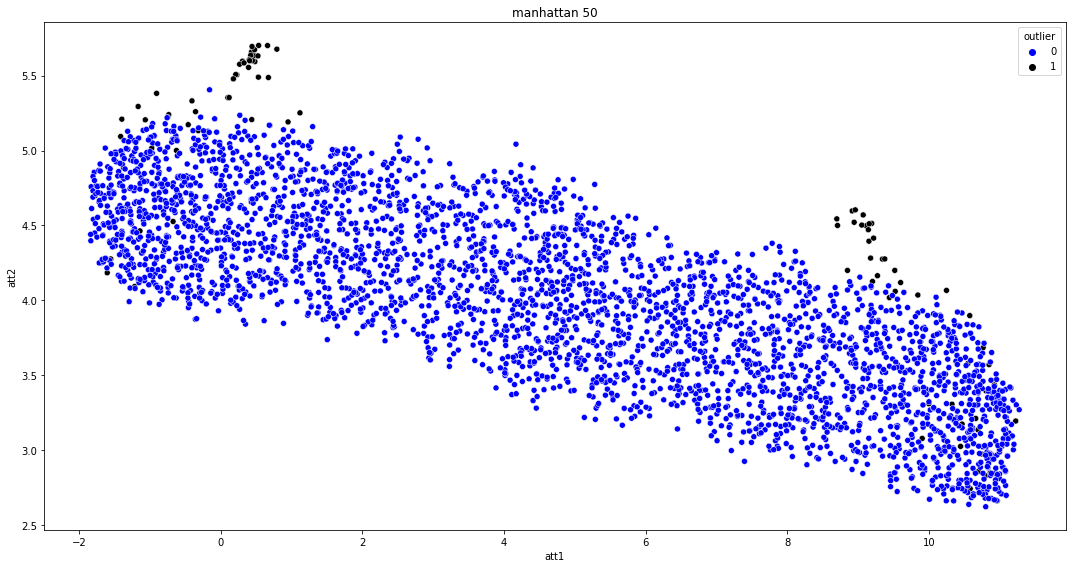

In [5]:
for i, n_neighbors in enumerate([5, 15, 30, 50]):
    for j, metric in enumerate(['euclidean', 'cosine', 'manhattan']):
        plt.figure(figsize=(15,8))
        emb = umap.UMAP(metric=metric, n_neighbors=n_neighbors)
        umap_temp = pd.DataFrame(emb.fit_transform(data.values), columns=['att1', 'att2'])
        sns.scatterplot(data=umap_temp, x='att1', y='att2', hue=target, palette=['blue', 'black'])
        plt.title(metric + ' ' + str(n_neighbors))
        plt.tight_layout()
        plt.show()

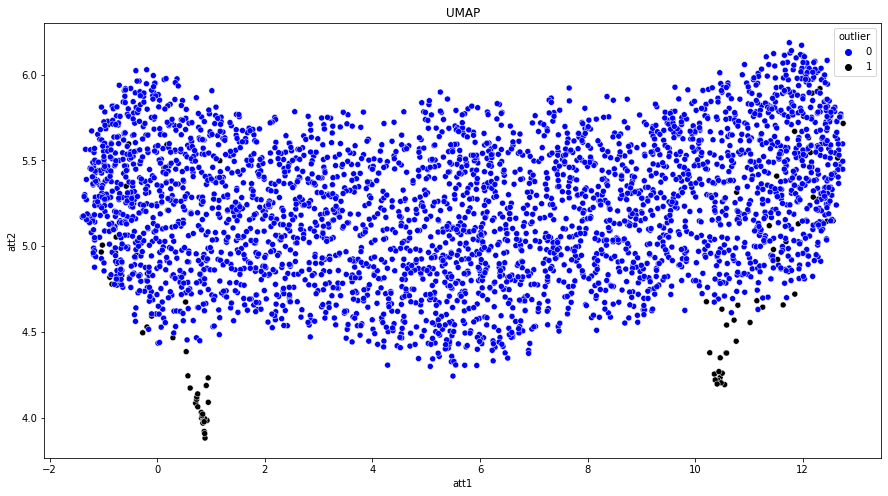

In [6]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=data_umap, x='att1', y='att2', hue=target, palette=['blue', 'black'])
plt.title('UMAP')
plt.show()

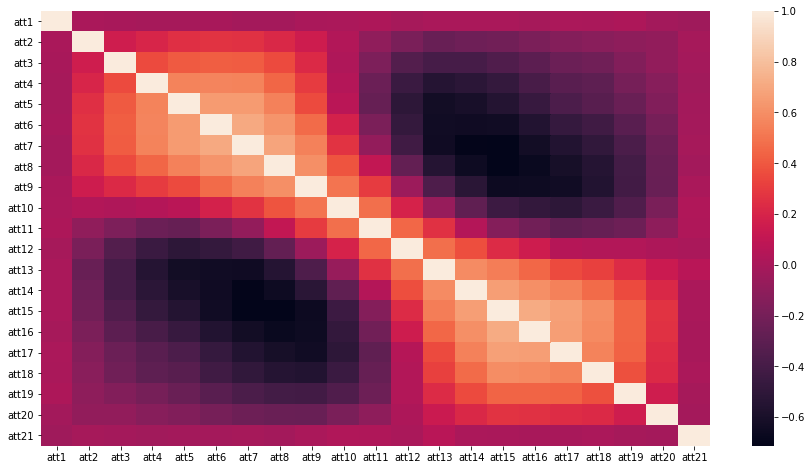

In [7]:
plt.figure(figsize=(15,8))
sns.heatmap(data.corr(), 
        xticklabels=data.columns,
        yticklabels=data.columns)
plt.show()

In [8]:
def get_score(target, pred):
    score1 = round(roc_auc_score(target, pred), 3)
    score2 = sum([1 if pred[i] == target[i] == 1 else 0 for i in range(len(pred))]) / sum(target)
    return score1, score2

## Statistics

In [9]:
def anomalies_by_std(data, parameter):
    mask = data.apply(lambda x: (x > np.abs(x.mean() - x.std()*parameter))
                              | (x > x.mean() + x.std()*parameter), axis=0)
    res = mask.any(1).astype(int).values
    return res

In [10]:
for parameter in [3, 4, 5, 6]:
    outliers = anomalies_by_std(data, parameter)
    outliers_norm = anomalies_by_std(data_normalized, parameter)
    outliers_umap = anomalies_by_std(data_umap, parameter)
    print(f'Parameter: {parameter}')
    print(f'Result data: {get_score(target, outliers)}')
    print(f'Result data_norm: {get_score(target, outliers_norm)}')
    print(f'Result data_umap: {get_score(target, outliers_umap)}')
    print()

Parameter: 3
Result data: (0.5, 1.0)
Result data_norm: (0.503, 0.02)
Result data_umap: (0.47, 0.94)

Parameter: 4
Result data: (0.465, 0.93)
Result data_norm: (0.5, 0.0)
Result data_umap: (0.5, 1.0)

Parameter: 5
Result data: (0.204, 0.2)
Result data_norm: (0.5, 0.0)
Result data_umap: (0.5, 1.0)

Parameter: 6
Result data: (0.358, 0.0)
Result data_norm: (0.5, 0.0)
Result data_umap: (0.5, 1.0)



In [11]:
def z_score(data, robust_type, border):
    if robust_type == 'mean':
        data_temp = (data - data.mean()).abs() / data.std()
    elif robust_type == 'mad':
        mad = np.median((data - data.median()).abs(), axis=0)
        data_temp = (data - data.median()).abs() / mad
    elif robust_type == 'iqr':
        iqr = data.quantile(0.75) - data.quantile(0.25)
        data_temp = (data - data.median()).abs() / iqr

    mask = data_temp.apply(lambda x: (x > x.quantile(border)), axis=0)
    res = mask.any(1).astype(int).values
    return res

In [12]:
for border in [0.9, 0.95, 0.98]:
    for robust_type in ['mean', 'mad', 'iqr']:
        outliers = z_score(data, robust_type, border)
        outliers_norm = z_score(data_normalized, robust_type, border)
        outliers_umap = z_score(data_umap, robust_type, border)
        print(f'Parameter: {parameter}, {robust_type}')
        print(f'Result data: {get_score(target, outliers)}')
        print(f'Result data_norm: {get_score(target, outliers_norm)}')
        print(f'Result data_umap: {get_score(target, outliers_umap)}')
        print()

Parameter: 6, mean
Result data: (0.553, 0.9)
Result data_norm: (0.553, 0.9)
Result data_umap: (0.746, 0.67)

Parameter: 6, mad
Result data: (0.573, 0.93)
Result data_norm: (0.573, 0.93)
Result data_umap: (0.756, 0.69)

Parameter: 6, iqr
Result data: (0.573, 0.93)
Result data_norm: (0.573, 0.93)
Result data_umap: (0.756, 0.69)

Parameter: 6, mean
Result data: (0.593, 0.74)
Result data_norm: (0.593, 0.74)
Result data_umap: (0.701, 0.49)

Parameter: 6, mad
Result data: (0.606, 0.75)
Result data_norm: (0.606, 0.75)
Result data_umap: (0.701, 0.49)

Parameter: 6, iqr
Result data: (0.606, 0.75)
Result data_norm: (0.606, 0.75)
Result data_umap: (0.701, 0.49)

Parameter: 6, mean
Result data: (0.577, 0.45)
Result data_norm: (0.577, 0.45)
Result data_umap: (0.68, 0.39)

Parameter: 6, mad
Result data: (0.606, 0.5)
Result data_norm: (0.606, 0.5)
Result data_umap: (0.696, 0.42)

Parameter: 6, iqr
Result data: (0.606, 0.5)
Result data_norm: (0.606, 0.5)
Result data_umap: (0.696, 0.42)



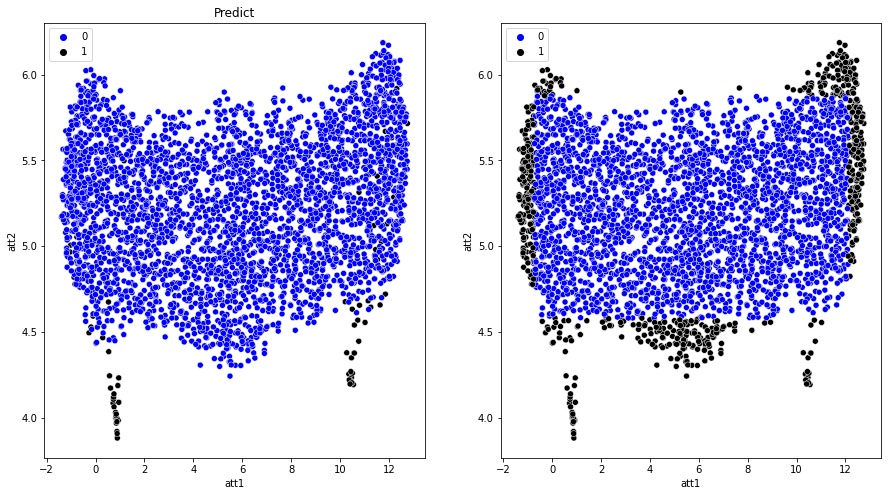

In [13]:
outliers_umap = z_score(data_umap, robust_type='mad', border=0.9)

fig, ax = plt.subplots(1, 2, figsize=(15,8))
sns.scatterplot(data=data_umap, x='att1', y='att2', hue=target.values, ax=ax[0], palette=['blue', 'black'])
ax[0].set_title('Real')
sns.scatterplot(data=data_umap, x='att1', y='att2', hue=outliers_umap, ax=ax[1], palette=['blue', 'black'])
ax[0].set_title('Predict')
plt.show()

In [14]:
def drop_by_median(data, param):
    mask = (data - data.median()).abs().sum(1)
    res = ((mask < mask.quantile((1-param))) | (mask > mask.quantile(param))).astype(int).values
    return res

In [15]:
for param in [0.9, 0.95, 0.98]:
    outliers = drop_by_median(data, param)
    outliers_norm = drop_by_median(data_normalized, param)
    outliers_umap = drop_by_median(data_umap, param)
    print(f'Parameter: {parameter}, {robust_type}')
    print(f'Result data: {get_score(target, outliers)}')
    print(f'Result data_norm: {get_score(target, outliers_norm)}')
    print(f'Result data_umap: {get_score(target, outliers_umap)}')
    print()

Parameter: 6, iqr
Result data: (0.479, 0.16)
Result data_norm: (0.464, 0.13)
Result data_umap: (0.495, 0.19)

Parameter: 6, iqr
Result data: (0.479, 0.06)
Result data_norm: (0.489, 0.08)
Result data_umap: (0.489, 0.08)

Parameter: 6, iqr
Result data: (0.495, 0.03)
Result data_norm: (0.5, 0.04)
Result data_umap: (0.505, 0.05)



In [16]:
def anomalies_by_boxplot(data, param):
    mask = data.apply(lambda x: (x < x.median() - param * (x.quantile(0.75) - x.quantile(0.25)))
                              | (x > x.median() + param * (x.quantile(0.75) - x.quantile(0.25))), axis=0)
    res = mask.any(1).astype(int).values
    return res

In [17]:
for parameter in [1, 1.5, 2, 3, 4]:
    outliers = anomalies_by_boxplot(data, parameter)
    outliers_norm = anomalies_by_boxplot(data_normalized, parameter)
    outliers_umap = anomalies_by_boxplot(data_umap, parameter)
    print(f'Parameter: {parameter}')
    print(f'Result data: {get_score(target, outliers)}')
    print(f'Result data_norm: {get_score(target, outliers_norm)}')
    print(f'Result data_umap: {get_score(target, outliers_umap)}')
    print()

Parameter: 1
Result data: (0.533, 1.0)
Result data_norm: (0.534, 1.0)
Result data_umap: (0.698, 0.5)

Parameter: 1.5
Result data: (0.616, 0.66)
Result data_norm: (0.616, 0.66)
Result data_umap: (0.665, 0.33)

Parameter: 2
Result data: (0.526, 0.13)
Result data_norm: (0.526, 0.13)
Result data_umap: (0.525, 0.05)

Parameter: 3
Result data: (0.5, 0.0)
Result data_norm: (0.5, 0.0)
Result data_umap: (0.5, 0.0)

Parameter: 4
Result data: (0.5, 0.0)
Result data_norm: (0.5, 0.0)
Result data_umap: (0.5, 0.0)



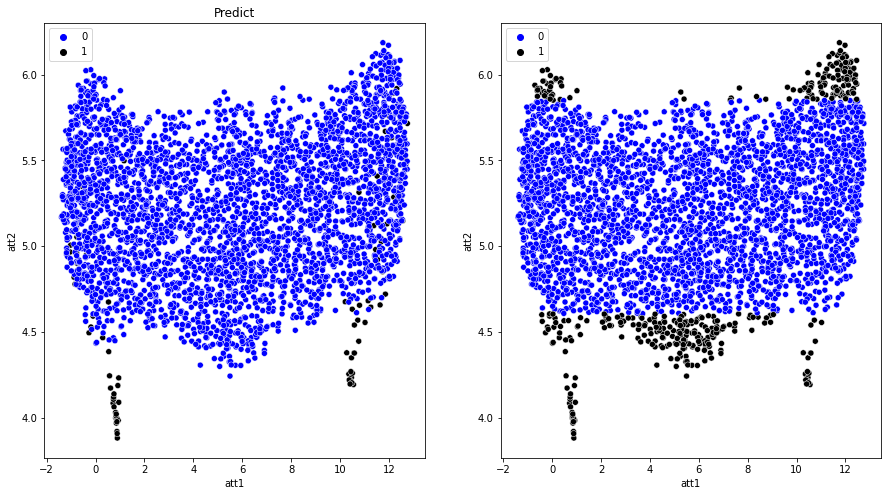

In [18]:
outliers = anomalies_by_boxplot(data_umap, param=1)

fig, ax = plt.subplots(1, 2, figsize=(15,8))
sns.scatterplot(data=data_umap, x='att1', y='att2', hue=target.values, ax=ax[0], palette=['blue', 'black'])
ax[0].set_title('Real')
sns.scatterplot(data=data_umap, x='att1', y='att2', hue=outliers, ax=ax[1], palette=['blue', 'black'])
ax[0].set_title('Predict')
plt.show()

## Supervised

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [20]:
def supervised_fit(data, model):
    model.fit(data, target)
    y_pred = model.predict(data)
    return y_pred

In [21]:
# logistic regression
outliers = supervised_fit(data, LogisticRegression())
outliers_norm = supervised_fit(data_normalized, LogisticRegression())
outliers_umap = supervised_fit(data_umap, LogisticRegression())

print(f'Result data: {get_score(target, outliers)}')
print(f'Result data_norm: {get_score(target, outliers_norm)}')
print(f'Result data_umap: {get_score(target, outliers_umap)}')

Result data: (0.523, 0.05)
Result data_norm: (0.524, 0.05)
Result data_umap: (0.5, 0.0)


In [22]:
# KNN
outliers = supervised_fit(data, KNeighborsClassifier())
outliers_norm = supervised_fit(data_normalized, KNeighborsClassifier())
outliers_umap = supervised_fit(data_umap, KNeighborsClassifier())

print(f'Result data: {get_score(target, outliers)}')
print(f'Result data_norm: {get_score(target, outliers_norm)}')
print(f'Result data_umap: {get_score(target, outliers_umap)}')

Result data: (0.69, 0.38)
Result data_norm: (0.65, 0.3)
Result data_umap: (0.705, 0.41)


## Unsupervised

#### DBSCAN

In [23]:
from sklearn.cluster import DBSCAN

def dbscan_check(data, params):
    model = DBSCAN(**params)
    model.fit_predict(data)
    pred = [1 if i == -1 else 0 for i in model.labels_]
    return get_score(target, pred)

In [24]:
%%time
scores = []
scores_norm = []
scores_umap = []

for metric in ['euclidean', 'cosine']:
    for eps in [0.1, 0.5, 1, 2, 3, 4, 5]:
        for min_samples in [5, 10, 15, 30, 40]:
            params = {'n_jobs':-1, 'eps':eps, 'min_samples':min_samples, 'metric':metric}
            score = dbscan_check(data, params)
            scores.append([params, score[0], score[1]])
            score_norm = dbscan_check(data_normalized, params)
            scores_norm.append([params, score_norm[0], score_norm[1]])
            score_umap = dbscan_check(data_umap, params)
            scores_umap.append([params, score_umap[0], score_umap[1]])

Wall time: 1min 14s


In [25]:
best_score = [(i[1], i[2]) for i in sorted(scores, key=lambda x: x[1], reverse=True)[:3]]
best_score_norm = [(i[1], i[2]) for i in sorted(scores_norm, key=lambda x: x[1], reverse=True)[:3]]
best_score_umap = [(i[1], i[2]) for i in sorted(scores_umap, key=lambda x: x[1], reverse=True)[:3]]
print('Score:', best_score)
print('Score norm: ', best_score_norm)
print('Score UMAP:', best_score_umap)

Score: [(0.68, 0.82), (0.653, 0.31), (0.653, 0.31)]
Score norm:  [(0.693, 0.67), (0.688, 0.82), (0.683, 0.6)]
Score UMAP: [(0.564, 0.2), (0.5, 1.0), (0.5, 1.0)]


In [26]:
[i[0] for i in sorted(scores, key=lambda x: x[1], reverse=True)[:3]]

[{'n_jobs': -1, 'eps': 4, 'min_samples': 5, 'metric': 'euclidean'},
 {'n_jobs': -1, 'eps': 0.1, 'min_samples': 30, 'metric': 'cosine'},
 {'n_jobs': -1, 'eps': 0.1, 'min_samples': 40, 'metric': 'cosine'}]

In [27]:
[i[0] for i in sorted(scores_norm, key=lambda x: x[1], reverse=True)[:3]]

[{'n_jobs': -1, 'eps': 3, 'min_samples': 15, 'metric': 'euclidean'},
 {'n_jobs': -1, 'eps': 3, 'min_samples': 30, 'metric': 'euclidean'},
 {'n_jobs': -1, 'eps': 3, 'min_samples': 10, 'metric': 'euclidean'}]

In [28]:
[i[0] for i in sorted(scores_umap, key=lambda x: x[1], reverse=True)[:3]]

[{'n_jobs': -1, 'eps': 0.1, 'min_samples': 5, 'metric': 'euclidean'},
 {'n_jobs': -1, 'eps': 0.1, 'min_samples': 30, 'metric': 'euclidean'},
 {'n_jobs': -1, 'eps': 0.1, 'min_samples': 40, 'metric': 'euclidean'}]

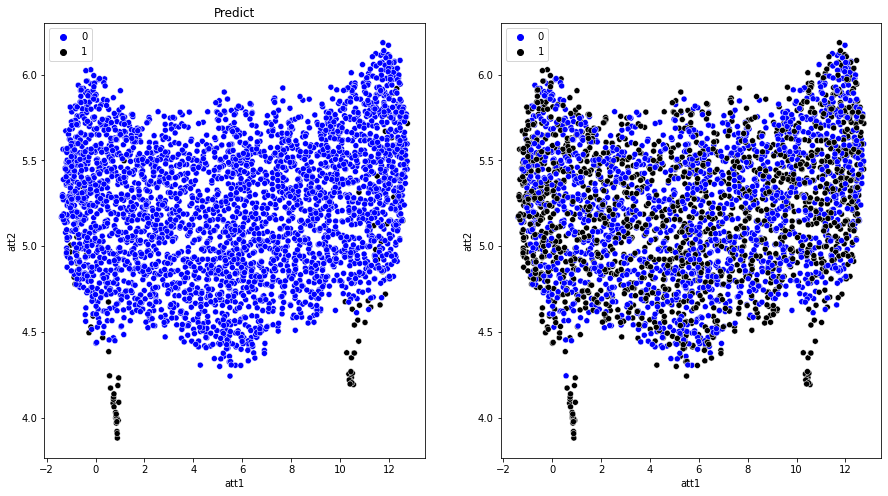

In [29]:
params = [i[0] for i in sorted(scores, key=lambda x: x[1], reverse=True)][0]
model = DBSCAN(**params)
model.fit_predict(data)
pred = [1 if i == -1 else 0 for i in model.labels_]

fig, ax = plt.subplots(1, 2, figsize=(15,8))
sns.scatterplot(data=data_umap, x='att1', y='att2', hue=target.values, ax=ax[0], palette=['blue', 'black'])
ax[0].set_title('Real')
sns.scatterplot(data=data_umap, x='att1', y='att2', hue=pred, ax=ax[1], palette=['blue', 'black'])
ax[0].set_title('Predict')
plt.show()

#### Isolation Forest

In [30]:
from sklearn.ensemble import IsolationForest

def isolation_forest_check(data, params):
    model = IsolationForest(**params)
    pred = model.fit_predict(data)
    pred = [1 if i == -1 else 0 for i in pred]
    return get_score(target, pred)

In [31]:
%%time
scores = []
scores_norm = []
scores_umap = []

for n_estimators in range(30, 150, 10):
    for max_samples in np.arange(0.1, 1.01, 0.1):
        for contamination in np.arange(0.01, 0.051, 0.01):
            params = {'n_jobs':-1, 'n_estimators':n_estimators, 'max_samples':max_samples, 'contamination':contamination}
            score = isolation_forest_check(data, params)
            scores.append([params, score[0], score[1]])
            score_norm = isolation_forest_check(data_normalized, params)
            scores_norm.append([params, score_norm[0], score_norm[1]])
            score_umap = isolation_forest_check(data_umap, params)
            scores_umap.append([params, score_umap[0], score_umap[1]])

Wall time: 13min 6s


In [32]:
best_score = [(i[1], i[2]) for i in sorted(scores, key=lambda x: x[1], reverse=True)[:3]]
best_score_norm = [(i[1], i[2]) for i in sorted(scores_norm, key=lambda x: x[1], reverse=True)[:3]]
best_score_umap = [(i[1], i[2]) for i in sorted(scores_umap, key=lambda x: x[1], reverse=True)[:3]]
print('Score:', best_score)
print('Score norm: ', best_score_norm)
print('Score UMAP:', best_score_umap)

Score: [(0.562, 0.17), (0.562, 0.17), (0.562, 0.17)]
Score norm:  [(0.567, 0.18), (0.562, 0.17), (0.562, 0.17)]
Score UMAP: [(0.773, 0.58), (0.757, 0.55), (0.752, 0.53)]


In [33]:
[i[0] for i in sorted(scores, key=lambda x: x[1], reverse=True)[:3]]

[{'n_jobs': -1, 'n_estimators': 30, 'max_samples': 0.2, 'contamination': 0.05},
 {'n_jobs': -1, 'n_estimators': 30, 'max_samples': 0.9, 'contamination': 0.05},
 {'n_jobs': -1,
  'n_estimators': 50,
  'max_samples': 0.30000000000000004,
  'contamination': 0.05}]

In [34]:
[i[0] for i in sorted(scores_norm, key=lambda x: x[1], reverse=True)[:3]]

[{'n_jobs': -1,
  'n_estimators': 70,
  'max_samples': 0.30000000000000004,
  'contamination': 0.05},
 {'n_jobs': -1, 'n_estimators': 30, 'max_samples': 1.0, 'contamination': 0.05},
 {'n_jobs': -1,
  'n_estimators': 100,
  'max_samples': 0.9,
  'contamination': 0.05}]

In [35]:
[i[0] for i in sorted(scores_umap, key=lambda x: x[1], reverse=True)[:3]]

[{'n_jobs': -1, 'n_estimators': 40, 'max_samples': 0.2, 'contamination': 0.05},
 {'n_jobs': -1,
  'n_estimators': 110,
  'max_samples': 0.30000000000000004,
  'contamination': 0.05},
 {'n_jobs': -1, 'n_estimators': 30, 'max_samples': 0.8, 'contamination': 0.04}]

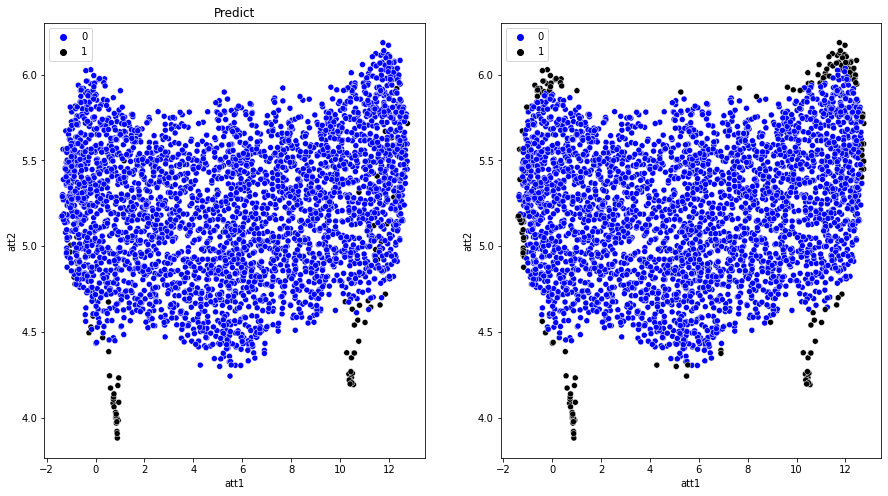

In [36]:
params = [i[0] for i in sorted(scores_umap, key=lambda x: x[1], reverse=True)][0]
model = IsolationForest(**params)
pred = model.fit_predict(data_umap)
pred = [1 if i == -1 else 0 for i in pred]

fig, ax = plt.subplots(1, 2, figsize=(15,8))
sns.scatterplot(data=data_umap, x='att1', y='att2', hue=target.values, ax=ax[0], palette=['blue', 'black'])
ax[0].set_title('Real')
sns.scatterplot(data=data_umap, x='att1', y='att2', hue=pred, ax=ax[1], palette=['blue', 'black'])
ax[0].set_title('Predict')
plt.show()

#### Elliptic Envelop

In [37]:
from sklearn.covariance import EllipticEnvelope
def elliptic_envelope_check(data, params):
    model = EllipticEnvelope(**params)
    pred = model.fit_predict(data)
    pred = [1 if i == -1 else 0 for i in pred]
    return get_score(target, pred)

In [38]:
%%time
scores = []
scores_norm = []
scores_umap = []

for contamination in np.arange(0.01, 0.051, 0.01):
    params = {'contamination':contamination}
    score = elliptic_envelope_check(data, params)
    scores.append([params, score[0], score[1]])
    score_norm = elliptic_envelope_check(data_normalized, params)
    scores_norm.append([params, score_norm[0], score_norm[1]])
    score_umap = elliptic_envelope_check(data_umap, params)
    scores_umap.append([params, score_umap[0], score_umap[1]])

Wall time: 25.1 s


In [39]:
best_score = [(i[1], i[2]) for i in sorted(scores, key=lambda x: x[1], reverse=True)[:3]]
best_score_norm = [(i[1], i[2]) for i in sorted(scores_norm, key=lambda x: x[1], reverse=True)[:3]]
best_score_umap = [(i[1], i[2]) for i in sorted(scores_umap, key=lambda x: x[1], reverse=True)[:3]]
print('Score:', best_score)
print('Score norm: ', best_score_norm)
print('Score UMAP:', best_score_umap)

Score: [(0.52, 0.07), (0.515, 0.07), (0.515, 0.08)]
Score norm:  [(0.52, 0.07), (0.515, 0.07), (0.515, 0.08)]
Score UMAP: [(0.696, 0.43), (0.654, 0.33), (0.639, 0.31)]


In [40]:
[i[0] for i in sorted(scores, key=lambda x: x[1], reverse=True)[:3]]

[{'contamination': 0.03}, {'contamination': 0.04}, {'contamination': 0.05}]

In [41]:
[i[0] for i in sorted(scores_norm, key=lambda x: x[1], reverse=True)[:3]]

[{'contamination': 0.03}, {'contamination': 0.04}, {'contamination': 0.05}]

In [42]:
[i[0] for i in sorted(scores_umap, key=lambda x: x[1], reverse=True)[:3]]

[{'contamination': 0.05}, {'contamination': 0.03}, {'contamination': 0.04}]

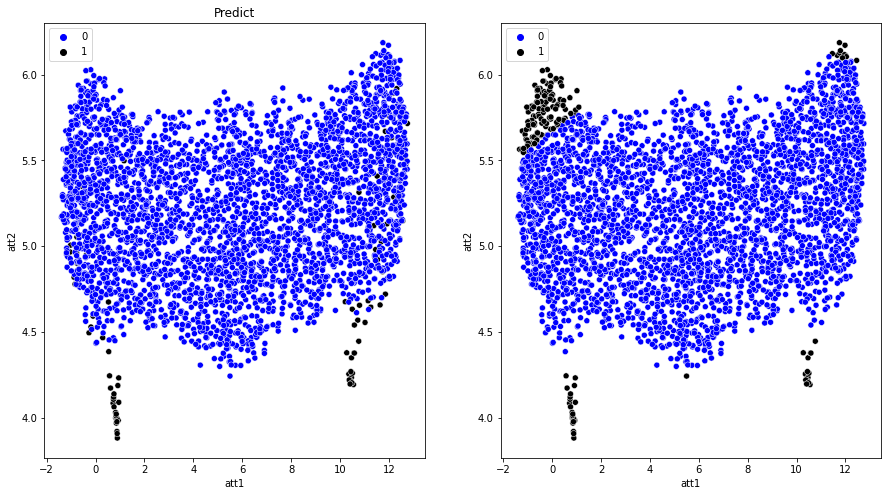

In [43]:
params = [i[0] for i in sorted(scores_umap, key=lambda x: x[1], reverse=True)][0]
model = EllipticEnvelope(**params)
pred = model.fit_predict(data_umap)
pred = [1 if i == -1 else 0 for i in pred]

fig, ax = plt.subplots(1, 2, figsize=(15,8))
sns.scatterplot(data=data_umap, x='att1', y='att2', hue=target.values, ax=ax[0], palette=['blue', 'black'])
ax[0].set_title('Real')
sns.scatterplot(data=data_umap, x='att1', y='att2', hue=pred, ax=ax[1], palette=['blue', 'black'])
ax[0].set_title('Predict')
plt.show()

### LOF

In [44]:
from sklearn.neighbors import LocalOutlierFactor
def lof_check(data, params):
    model = LocalOutlierFactor(**params)
    pred = model.fit_predict(data)
    pred = [1 if i == -1 else 0 for i in pred]
    return get_score(target, pred)

In [45]:
%%time
scores = []
scores_norm = []
scores_umap = []

for n_neighbors in [5, 10, 20, 30]:
    for leaf_size in [20, 30, 40]:
        for metric in ['minkowski', 'cosine', 'euclidean', 'manhattan']:
            for contamination in np.arange(0.01, 0.051, 0.01):
                params = {'n_jobs':-1, 'n_neighbors':n_neighbors, 'leaf_size':leaf_size,
                          'metric':metric, 'contamination':contamination}
                score = lof_check(data, params)
                scores.append([params, score[0], score[1]])
                score_norm = lof_check(data_normalized, params)
                scores_norm.append([params, score_norm[0], score_norm[1]])
                score_umap = lof_check(data_umap, params)
                scores_umap.append([params, score_umap[0], score_umap[1]])

Wall time: 3min 2s


In [46]:
best_score = [(i[1], i[2]) for i in sorted(scores, key=lambda x: x[1], reverse=True)[:3]]
best_score_norm = [(i[1], i[2]) for i in sorted(scores_norm, key=lambda x: x[1], reverse=True)[:3]]
best_score_umap = [(i[1], i[2]) for i in sorted(scores_umap, key=lambda x: x[1], reverse=True)[:3]]
print('Score:', best_score)
print('Score norm: ', best_score_norm)
print('Score UMAP:', best_score_umap)

Score: [(0.701, 0.44), (0.701, 0.44), (0.701, 0.44)]
Score norm:  [(0.665, 0.37), (0.665, 0.37), (0.665, 0.37)]
Score UMAP: [(0.721, 0.48), (0.721, 0.48), (0.721, 0.48)]


In [47]:
[i[0] for i in sorted(scores, key=lambda x: x[1], reverse=True)[:3]]

[{'n_jobs': -1,
  'n_neighbors': 30,
  'leaf_size': 20,
  'metric': 'cosine',
  'contamination': 0.05},
 {'n_jobs': -1,
  'n_neighbors': 30,
  'leaf_size': 30,
  'metric': 'cosine',
  'contamination': 0.05},
 {'n_jobs': -1,
  'n_neighbors': 30,
  'leaf_size': 40,
  'metric': 'cosine',
  'contamination': 0.05}]

In [48]:
[i[0] for i in sorted(scores_norm, key=lambda x: x[1], reverse=True)[:3]]

[{'n_jobs': -1,
  'n_neighbors': 20,
  'leaf_size': 20,
  'metric': 'cosine',
  'contamination': 0.05},
 {'n_jobs': -1,
  'n_neighbors': 20,
  'leaf_size': 30,
  'metric': 'cosine',
  'contamination': 0.05},
 {'n_jobs': -1,
  'n_neighbors': 20,
  'leaf_size': 40,
  'metric': 'cosine',
  'contamination': 0.05}]

In [49]:
[i[0] for i in sorted(scores_umap, key=lambda x: x[1], reverse=True)[:3]]

[{'n_jobs': -1,
  'n_neighbors': 30,
  'leaf_size': 20,
  'metric': 'manhattan',
  'contamination': 0.05},
 {'n_jobs': -1,
  'n_neighbors': 30,
  'leaf_size': 30,
  'metric': 'manhattan',
  'contamination': 0.05},
 {'n_jobs': -1,
  'n_neighbors': 30,
  'leaf_size': 40,
  'metric': 'manhattan',
  'contamination': 0.05}]

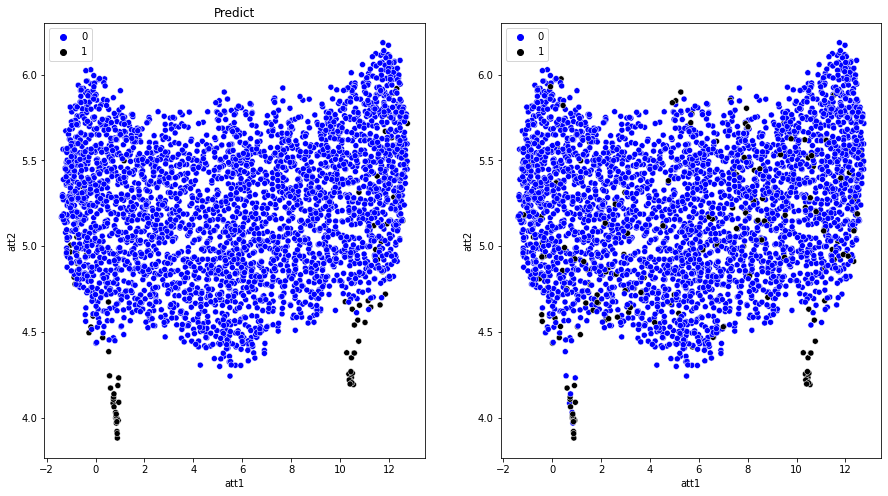

In [50]:
params = [i[0] for i in sorted(scores, key=lambda x: x[1], reverse=True)][0]
model = LocalOutlierFactor(**params)
pred = model.fit_predict(data)
pred = [1 if i == -1 else 0 for i in pred]

fig, ax = plt.subplots(1, 2, figsize=(15,8))
sns.scatterplot(data=data_umap, x='att1', y='att2', hue=target.values, ax=ax[0], palette=['blue', 'black'])
ax[0].set_title('Real')
sns.scatterplot(data=data_umap, x='att1', y='att2', hue=pred, ax=ax[1], palette=['blue', 'black'])
ax[0].set_title('Predict')
plt.show()